In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [16]:
@jit(nopython=True)
# Function to initialize N positions randomly inside a unit circle
def initialize(N):
    p = []
    while len(p) < N:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            p.append([x, y])
    return np.array(p)

In [17]:
@jit(nopython=True)
# Function to return a small perturbation
def perturb(sigma):
    k = np.random.normal(0, sigma)
    # if k > 0:
    #     return k
    # else:
    #     return k/10
    return  abs(k)

In [18]:
@jit(nopython=True)
# Function to check whether particles are within a unit circle
def in_circle(p):
    return np.sum(p**2) <= 1

In [19]:
@jit(nopython=True)
# Function to calculate the energy of the system
def energy(p):
    E = 0
    for i in range(len(p)):
        for j in range(i+1, len(p)):
            E += 1/np.linalg.norm(p[i] - p[j])
    return E

In [20]:
@jit(nopython=True)
# Function to calculate the force on a particle
def force(p, i):
    f = np.zeros(2)
    for j in range(len(p)):
        if j != i:
            f += (p[i] - p[j]) / np.linalg.norm(p[i] - p[j])**3
    return f

In [21]:
@jit(nopython=True)
# Function to induce one perturbation on the system
def forced_perturb(p, i, sigma):
        dir = force(p, i)/np.linalg.norm(force(p, i)) # Calculate direction of force

        p[i] += dir*perturb(sigma)
        
        if not in_circle(p[i]): # Check if perturbation is valid
            p[i] *= 1/np.linalg.norm(p[i]) # If not, move particle back into the circle
        return p

In [22]:
@jit(nopython=True)
# Function to induce one perturbation on the system
def random_perturb(p, i, sigma):
        p[i] += np.random.normal(0, sigma, 2)
        
        if not in_circle(p[i]): # Check if perturbation is valid
            p[i] *= 1/np.linalg.norm(p[i]) # If not, move particle back into the circle
        return p

In [23]:
@jit(nopython=True)
# Function to calculate the acceptance probability
def acceptance_probability(E_old, E_new, T):
    if E_new < E_old:
        return 1
    else:
        return np.exp(-(E_new - E_old) / T)


In [24]:
@jit(nopython=True)
# Function to find new position of particles using random perturbation
def random_new_positions(p, E, T, sigma):
    p_new = p.copy()
    E_new = E
    
    # Perturb the system
    for i in range(len(p)):
        p_trial = random_perturb(p_new, i, sigma)
        E_trial = energy(p_trial)

        # Check if perturbation is accepted
        if acceptance_probability(E_new, E_trial, T) > np.random.uniform(0, 1):
            p_new = p_trial
            E_new = E_trial
            
    return p_new, E_new

In [25]:
@jit(nopython=True)
# Function to find new position of partcles using forced perturbation
def forced_new_positions(p, E, T, sigma):
    p_new = p.copy()
    E_new = E
    
    # Perturb the system
    for i in range(len(p)):
        p_trial = forced_perturb(p_new, i, sigma)
        E_trial = energy(p_trial)

        # Check if perturbation is accepted
        if acceptance_probability(E_new, E_trial, T) > np.random.uniform(0, 1):
            p_new = p_trial
            E_new = E_trial
            
    return p_new, E_new

In [26]:
# Function to plot the positions of the particles
def plot_positions(p):
    fig, ax = plt.subplots()
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)
    ax.scatter(p[:,0], p[:,1], color='red', s=4)
    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)
    plt.axhline(y=0, color='blue')
    plt.axvline(x=0, color='blue')
    plt.title("Particle positions for N = " + str(len(p)))
    plt.show()

In [27]:
@jit(nopython=True)
# Function to run the annealing process
def annealing(N, T_max, T_min, cooling_schedule, no_iterations):
    # Initialize positions
    p = initialize(N)

    # Initialize energy
    E = energy(p)

    # Initialize temperature
    T = T_max

    # Initialize lists to store minima per temperature
    E_min_per_temp = [E]
    p_min_per_temp = [p]

    # Annealing process
    while T > T_min:
        # Initialize lists to store results per iteration
        E_iter = []
        p_iter = []


        # Markov chain
        for k in range(no_iterations):
            # Initialize standard deviation of random normal perturbation
            sigma = T

            # Inducing some random perturbations
            if k == no_iterations/10:
                p, E = random_new_positions(p, E, T, sigma)

            # Get forced new positions for each iteration
            p, E = forced_new_positions(p, E, T, sigma)
            #print("E: ", E)
            
            E_iter.append(E)
            p_iter.append(p)

        # Store minimum energy and corresponding positions for each temperature
        E_min_per_temp.append(min(E_iter))
        p_min_per_temp.append(p_iter[E_iter.index(min(E_iter))])
        
        #print("E min per temperature: ", E_min_per_temp[-1])
        #plot_positions(p_min_per_temp[-1])
        
        # Cool system
        T *= cooling_schedule

    return p_min_per_temp, E_min_per_temp    

1


E:  134.38769392214672
E_min:  133.8282480441429
2
E:  133.81658534626558
E_min:  133.81658534626558
3
E:  134.49944262881831
4
E:  133.8167244822656
5
E:  134.38720294083657
6
E:  134.3873926117056
7
E:  134.4921807854706
8
E:  134.3871764949428
9
E:  134.38737874432312
10
E:  134.38726671241045
11
E:  134.38757794036096
12
E:  134.3878516099335
13
E:  134.3874861984745
14
E:  134.38737167204314
15
E:  134.38774468347262
16
E:  134.38739706688938
17
E:  134.38760185232334
18
E:  134.38732261814897
19
E:  134.38780881505843
20
E:  134.3870977233946
E_global_min:  133.81658534626558


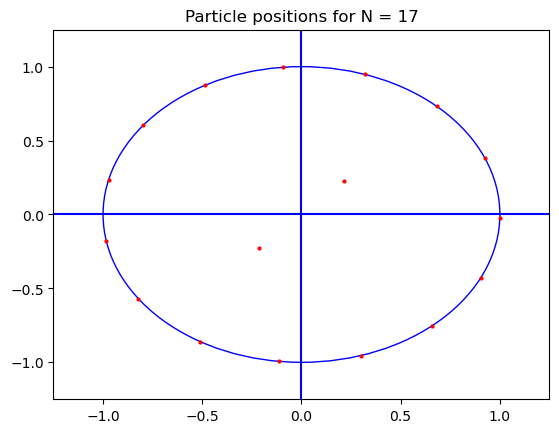

In [28]:
particles = 17
max_temp = 10
min_temp = 0.01
alpha = 0.9
iterations = 100

E_min = np.inf
a = 0
for _ in range(20):
    a += 1
    print(a)
    positions, energies = annealing(particles, max_temp, min_temp, alpha, iterations)
    print("E: ", energies[-1])
    if min(energies) < E_min:
        E_min = min(energies) 
        print("E_min: ", E_min)   
        p_min = positions[energies.index(min(energies))]
print("E_global_min: ", E_min)
plot_positions(p_min)

In [5]:
import simulations_jit.SimulatedAnnealingForces as saf 

particles = 2
max_temp = 10
min_temp = 0.01
alpha = 0.9
iterations = 100
a, b = saf.annealing(particles, max_temp, min_temp, alpha, iterations)
print(a)
saf.plot_positions(a)

[[-0.92335801  0.38394008]
 [ 0.91627023 -0.40056069]]


AttributeError: module 'simulations_jit.SimulatedAnnealingForces' has no attribute 'plot_positions'

In [3]:
plot_positions(a)

NameError: name 'plot_positions' is not defined